In [87]:
from get_clean_data import read_table, get_o3_segment
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gwpy.table import (Table, EventTable)
import h5py
from gwtrigfind import find_trigger_files
from pathlib import Path

In [64]:
file = '/home/detchar/triggers/L1/GDS_CALIB_STRAIN_OMICRON/12539/L1-GDS_CALIB_STRAIN_OMICRON-1253952766-320.h5'

triggers = h5py.File(file, "r")["triggers"]  # This is an h5py dataset

# Convert to pandas DataFrame
df = pd.DataFrame({
    "peak_GPS_time": triggers["peak_GPS_time"][:],
    "peak_frequency": triggers["peak_frequency"][:],
    "GPS_time_start": triggers["GPS_time_start"][:],
    "GPS_time_end": triggers["GPS_time_end"][:],
    "frequency_start": triggers["frequency_start"][:],
    "frequency_end": triggers["frequency_end"][:],
    "SNR": triggers["SNR"][:],
    "Q": triggers["Q"][:],
    "Amplitude": triggers["Amplitude"][:],
    "phase": triggers["phase"][:]
})

ValueError: Field peak_GPS_time does not appear in this type.

In [99]:
%timeit
ifo, run = 'L1', 'O3a'
start, end = get_o3_segment(run)
hoft_channel = f'{ifo}:GDS-CALIB_STRAIN'
file_list = find_trigger_files(hoft_channel, 'omicron', start, end)

def read_gps_times(file_list):
    """
    Reads only the GPS start and end times from multiple HDF5 trigger files.
    Returns a single sorted numpy array of starts and ends.
    """
    starts_list = []
    ends_list = []

    for file in file_list:
        with h5py.File(file[7:], "r") as f:
            triggers = f["triggers"]
            starts_list.append(triggers["tstart"][:])
            ends_list.append(triggers["tend"][:])

    # Concatenate all files
    all_starts = np.concatenate(starts_list)
    all_ends   = np.concatenate(ends_list)

    # Sort by start times
    sort_idx = np.argsort(all_starts)
    all_starts = all_starts[sort_idx]
    all_ends   = all_ends[sort_idx]

    return all_starts, all_ends

starts, ends = read_gps_times(file_list)

In [101]:
def find_gaps_numpy(starts, ends, lower_bound, upper_bound):
    """
    Vectorized gap calculation between consecutive triggers.
    
    Parameters:
        starts (np.ndarray): start times of triggers
        ends (np.ndarray): end times of triggers
        lower_bound (float): min gap in seconds
        upper_bound (float): max gap in seconds

    Returns:
        np.ndarray: shape (N,2) of valid gaps [gap_start, gap_end]
    """
    # Compute gaps vectorized
    gap_starts = ends[:-1]
    gap_ends   = starts[1:]
    gaps       = gap_ends - gap_starts

    # Apply bounds
    valid_mask = (gaps > lower_bound) & (gaps < upper_bound)

    # Return array of (gap_start, gap_end)
    return np.column_stack((gap_starts[valid_mask], gap_ends[valid_mask]))

gaps = find_gaps_numpy(starts, ends, 7, 30)

(array([1.9014e+04, 3.5260e+03, 7.6200e+02, 1.4400e+02,
        4.8000e+01, 1.3000e+01, 5.0000e+00, 2.0000e+00,
        2.0000e+00, 2.0000e+00]),
 array([ 7.00024295,  9.22438855, 11.44853415, 13.67267976,
        15.89682536, 18.12097096, 20.34511657, 22.56926217,
        24.79340777, 27.01755338, 29.24169898]),
 <BarContainer object of 10 artists>)

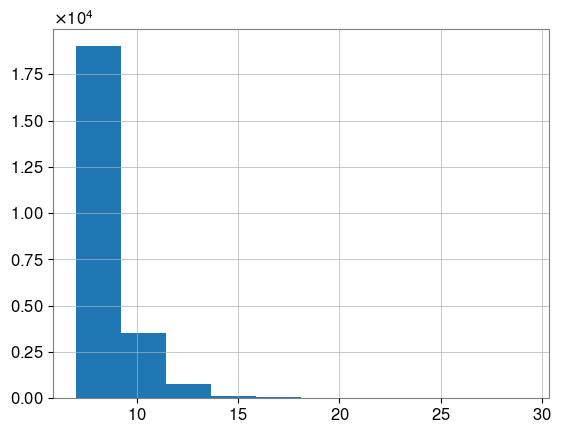

In [109]:
plt.hist(gaps[:, 1] - gaps[:, 0])

In [5]:
run = 'O3a'
ifo = 'L1'
start, end = get_o3_segment(run)
hoft_channel = f'{ifo}:GDS-CALIB_STRAIN'
lower_bound, upper_bound = 7, 30

df = read_table(start, end, hoft_channel)

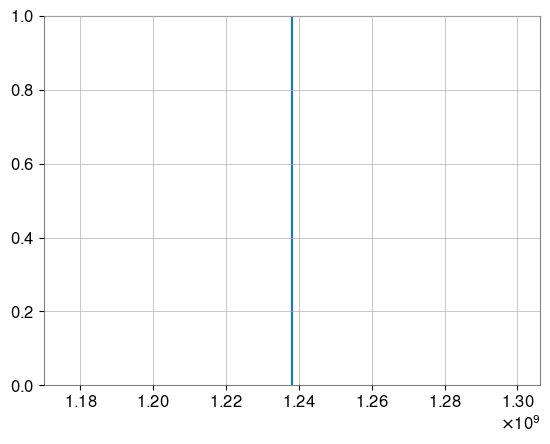

In [16]:
plt.axvline(df.iloc[0]['start'])
plt.axvline(df.iloc[0]['end'])

In [48]:
df_ = df.sort_values(by='start')
gap_starts = df_["end"].iloc[:-1].to_numpy()
gap_ends = df_["start"].iloc[1:].to_numpy()
gaps = gap_ends - gap_starts
lower_bound = 7
upper_bound = 1000
# Filter gaps based on the given bounds
valid_mask = (gaps > lower_bound) & (gaps < upper_bound)
len(list(zip(gap_starts[valid_mask], gap_ends[valid_mask])))

28

Index([   282,    283,    284,    285,    286,    287,    288,    289,    290,
          291,
       ...
       219281, 219282, 219283, 219284, 219285, 219286, 220304, 220305, 220306,
       220307],
      dtype='int64', length=220492)

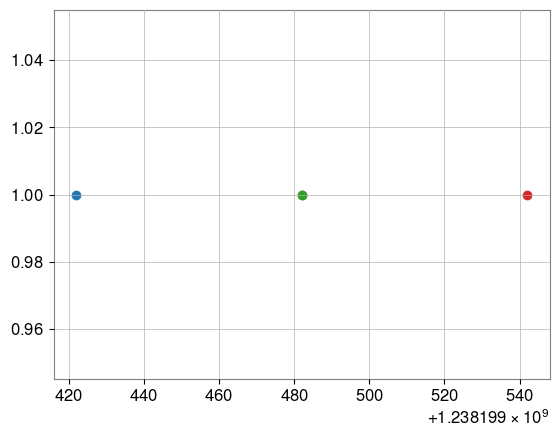

In [41]:
plt.scatter(df["start"].iloc[0], 1)
plt.scatter(df["end"].iloc[0], 1)

plt.scatter(df["start"].iloc[1], 1)
plt.scatter(df["end"].iloc[1], 1)

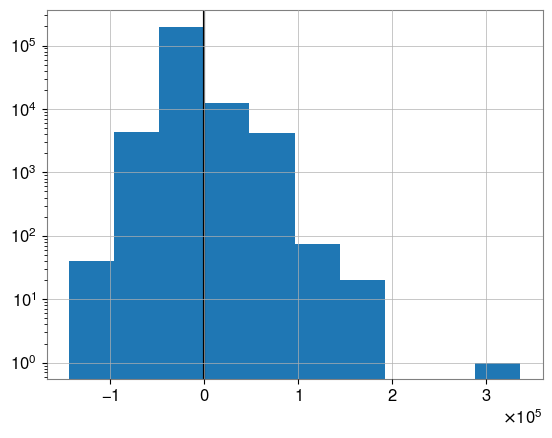

In [26]:
plt.hist(gaps)
plt.yscale('log')
plt.axvline(7, c='black')
plt.axvline(30, c='black')
